# GIVE ME SOME CREDIT

This notebook is created 9 years after this competition ended. The main aim of this project is to predict the probabily whether a customer will default in the future given his record present in the dataset. We will be using **predict_proba** to determine the delinquency probabilities of the customer.

The Highlights of the notebook are:

- **Exploratory Data Analysis**
    - **Outlier Analysis
    - **Null Handling
    - **Distribution Analysis
    - **Skewness Reduction (using Box Cox Transformation)
- **Feature Engineering**
- **LightGBM using RandomizedSearchCV (Classification)**
    - **Evaluation Metrics**
        - Mean Squared Error
        - Root Mean Squared Error
        - Mean Absolute Error
        - Mean Squared Logarithmic Error
        - Root Mean Square Logarithmic Error
        - Accuracy on Training Set
        - Accuracy on Test Set
        - F-Beta Score (Beta = 2)
        - F1 Score
        - Precision
        - Recall
        - Confusion Matrix
        - AUC Curve
    - **Probability Prediction on Validation Sets**
    - **Delinquency Prediction on Validation Sets**
    - **Feature Importances**
        - Summary Plot
        - SHAP Analysis
- **XGBoost using RandomizedSearchCV (Classification)**
    - **Evaluation Metrics**
        - Mean Squared Error
        - Root Mean Squared Error
        - Mean Absolute Error
        - Mean Squared Logarithmic Error
        - Root Mean Square Logarithmic Error
        - Accuracy on Training Set
        - Accuracy on Test Set
        - F-Beta Score (Beta = 2)
        - F1 Score
        - Precision
        - Recall
        - Confusion Matrix
        - AUC Curve
    - **Probability Prediction on Validation Sets**
    - **Delinquency Prediction on Validation Sets**
    - **Feature Importances**
        - Summary Plot
        - SHAP Analysis
        
        
Let's begin with importing the libraries we will be requiring for this notebook

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import ensemble
from sklearn import tree
from sklearn import linear_model
import os, datetime, sys, random, time
import seaborn as sns
import xgboost as xgs
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mlxtend import classifier
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import stats, special
import shap
#import catboost as ctb

In [3]:
trainingData = pd.read_csv('cs-training.csv')
testData = pd.read_csv('cs-test.csv')

In [4]:
trainingData.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# Exploratory Data Analysis

Let's first try to identify the column by column datatypes and null values.

In [5]:
trainingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

Some of the observations are:

- There are 150,000 rows for 11 features in our data.
- We see in the training data, that all the datatypes belong to a numeric class i.e. **int** and **float**.
- Columns **MonthlyIncome** and **NumberOfDependents** have some null values

In [6]:
trainingData.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


From here we can conclude that the column **Unnamed: 0** will have no significance in the predictive modelling because it represents ID of the customer,

In [7]:
print(trainingData.shape)
print(testData.shape)

(150000, 12)
(101503, 12)


Performing similar analysis on the Test Data.

In [8]:
testData.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [9]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            101503 non-null  int64  
 1   SeriousDlqin2yrs                      0 non-null       float64
 2   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 3   age                                   101503 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 5   DebtRatio                             101503 non-null  float64
 6   MonthlyIncome                         81400 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 8   NumberOfTimes90DaysLate               101503 non-null  int64  
 9   NumberRealEstateLoansOrLines          101503 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 11  

Some of the observations on the testing data:

- The total rows for our 11 features are 101,503. 
- Like the Training Data (as it should be), we observe numeric class's datatypes i.e. **int** and **float**.
- Nulls were observed for features **MonthlyIncome** and **NumberOfDependents** just like the training data.

In [10]:
testData.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,101503.000000,0.0,101503.000000,101503.000000,101503.000000,101503.000000,8.140000e+04,101503.000000,101503.000000,101503.000000,101503.000000,98877.000000
mean,50752.000000,NaN,5.310000,52.405436,0.453770,344.475020,6.855036e+03,8.453514,0.296691,1.013074,0.270317,0.769046
std,29301.536524,NaN,196.156039,14.779756,4.538487,1632.595231,3.650860e+04,5.144100,4.515859,1.110253,4.503578,1.136778
min,1.000000,NaN,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25376.500000,NaN,0.030131,41.000000,0.000000,0.173423,3.408000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,50752.000000,NaN,0.152586,52.000000,0.000000,0.364260,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,76127.500000,NaN,0.564225,63.000000,0.000000,0.851619,8.200000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,101503.000000,NaN,21821.000000,104.000000,98.000000,268326.000000,7.727000e+06,85.000000,98.000000,37.000000,98.000000,43.000000


Let's create a copy of our two datasets, so the changes we are gonna make forward does not affect the original data.

In [11]:
finalTrain = trainingData.copy()
finalTest = testData.copy()

Since, we need to predict the probability of Delinquency in the test data, we need to remove the additional column from it first.

In [12]:
finalTest.drop('SeriousDlqin2yrs', axis=1, inplace = True)

Also as mentioned above, let's take the ID column i.e. **Unnamed: 0** and store it in seperate variables.

In [13]:
trainID = finalTrain['Unnamed: 0']
testID = finalTest['Unnamed: 0']

finalTrain.drop('Unnamed: 0', axis=1, inplace=True)
finalTest.drop('Unnamed: 0', axis=1, inplace=True)

### Imbalance Ratio

Since we have a total data of 150,000. There are high chances that it can be an imbalanced dataset. Therefore, checking the positive and negative delinquency ratio.

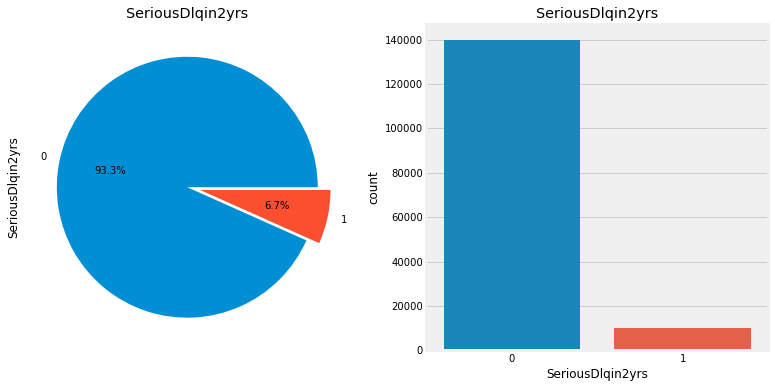

In [14]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
finalTrain['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=axes[0])
axes[0].set_title('SeriousDlqin2yrs')
#ax[0].set_ylabel('')
sns.countplot('SeriousDlqin2yrs',data=finalTrain,ax=axes[1])
axes[1].set_title('SeriousDlqin2yrs')
plt.show()

The ratio of negative to positive delinquency outliers are found to be 93.3% to 6.7%, which is approximately a ratio of 14:1. Therefore, our dataset is highly imbalanced. We cannot rely on the accuracy scores to predict the model's success. Many other evaluation metrics would be considered here. But more on that later.

Now let's move on the Outlier Analysis section of our EDA. Here we will remove potential outliers which might affect our predictive modelling.

### Outlier Analysis

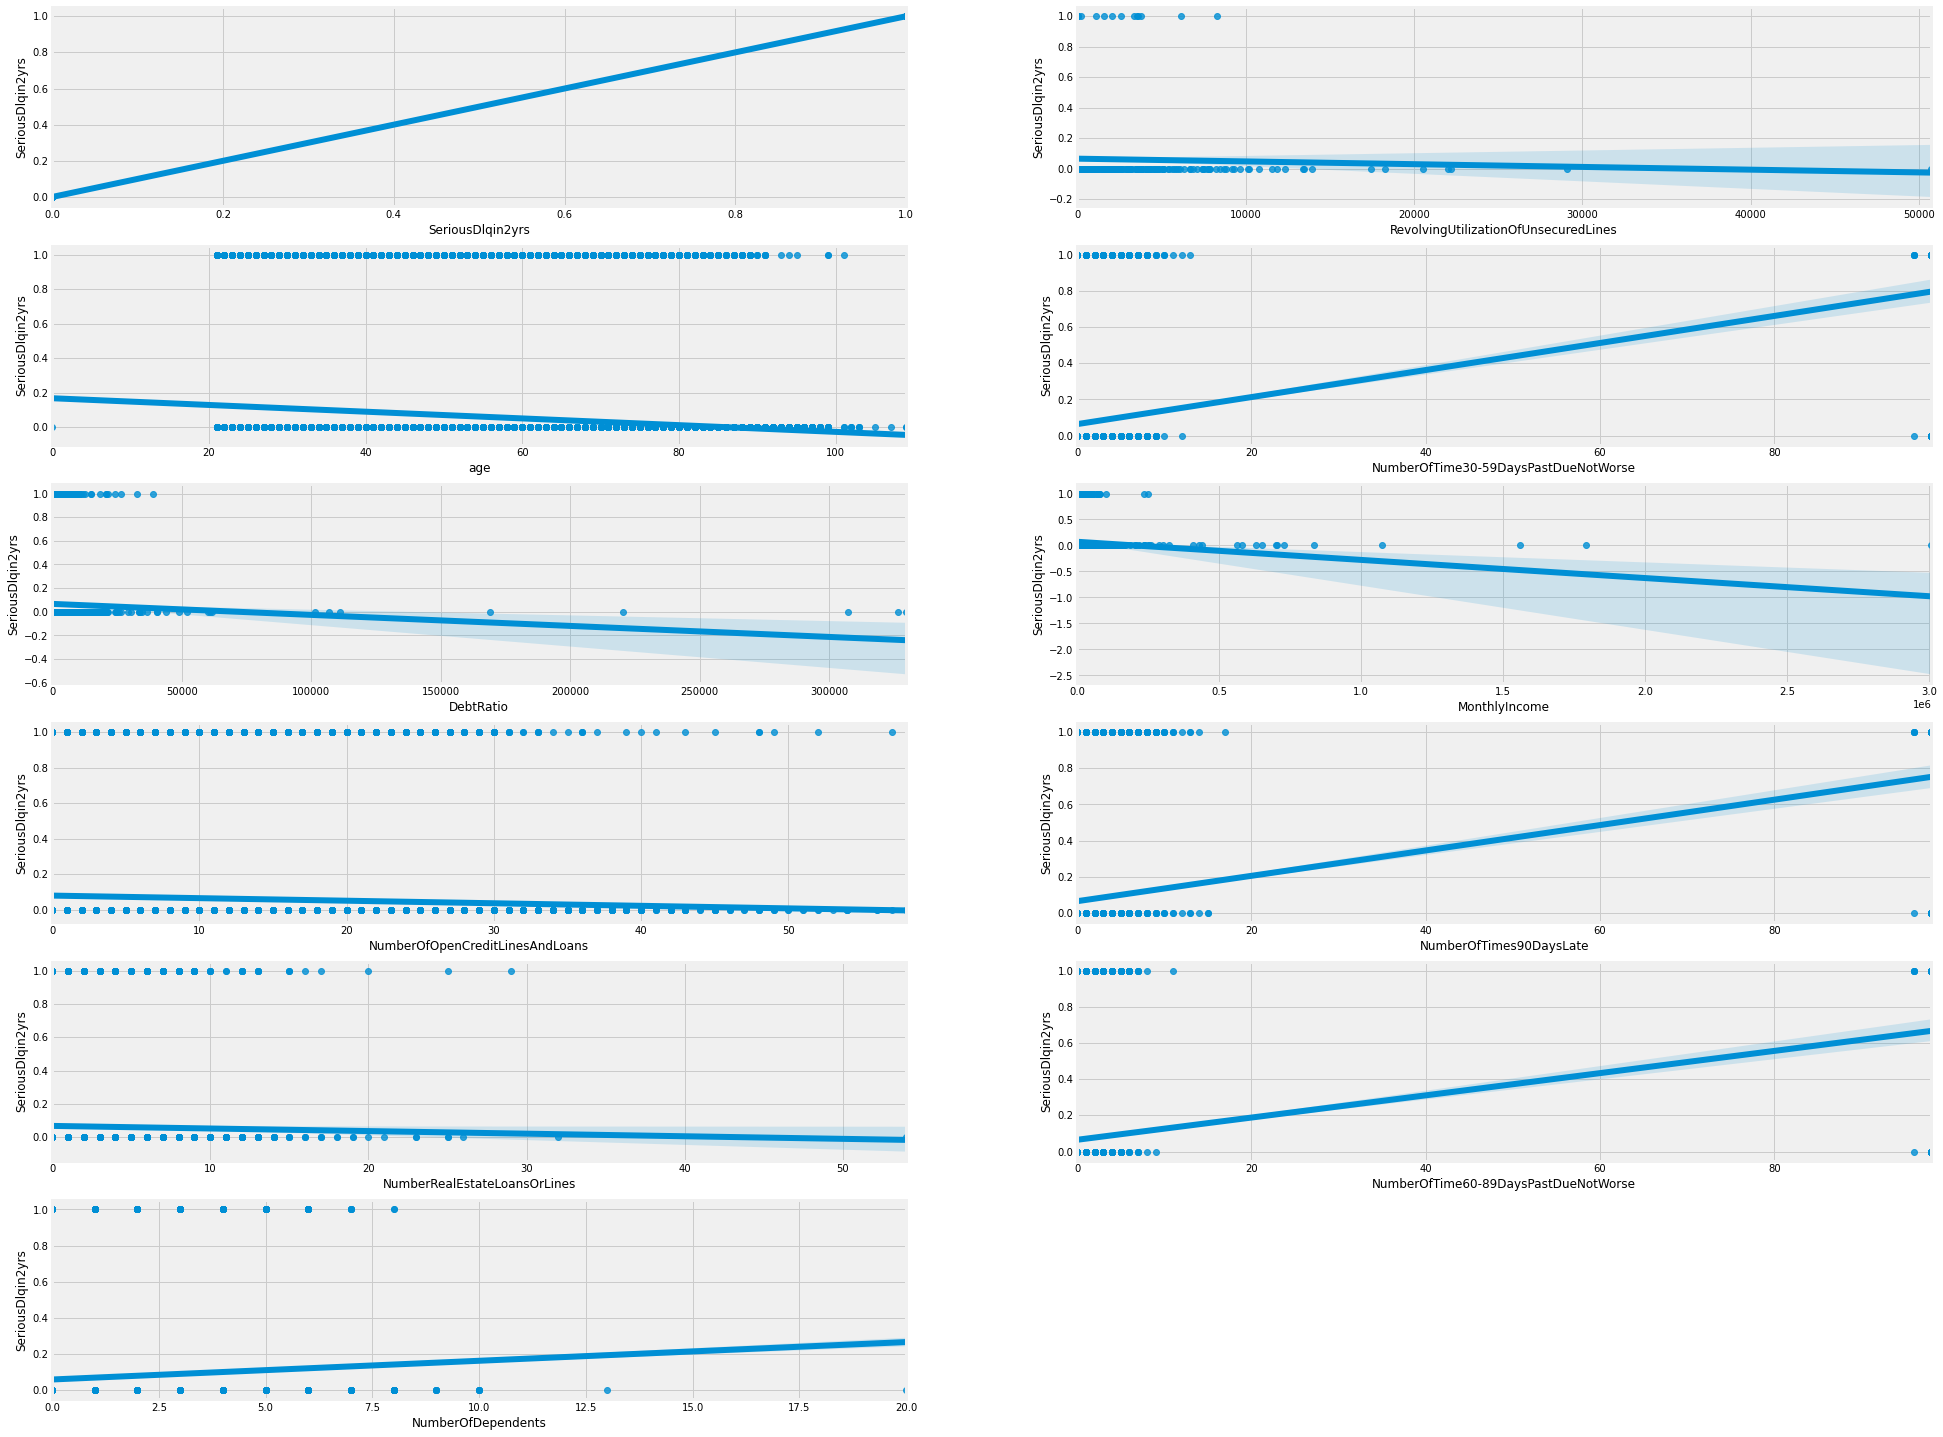

In [15]:
fig = plt.figure(figsize=[30,30])
for col,i in zip(finalTrain.columns,range(1,13)):
    axes = fig.add_subplot(7,2,i)
    sns.regplot(finalTrain[col],finalTrain.SeriousDlqin2yrs,ax=axes)
plt.show()

From the above graphs we can observe:

- In the columns **NumberOfTime30-59DaysPastDueNotWorse** , **NumberOfTime60-89DaysPastDueNotWorse** and **NumberOfTimes90DaysLate**, we see delinquency range beyond 90 which is common across all 3 features.
- There are some unusually high values for **DebtRatio** and **RevolvingUtilizationOfUnsecuredLines**.

Step 1: Fixing the columns **NumberOfTime30-59DaysPastDueNotWorse** , **NumberOfTime60-89DaysPastDueNotWorse** and **NumberOfTimes90DaysLate**

In [16]:
print("Unique values in '30-59 Days' values that are more than or equal to 90:",np.unique(finalTrain[finalTrain['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(finalTrain[finalTrain['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                       ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(finalTrain[finalTrain['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                    ['NumberOfTimes90DaysLate']))


print("Unique values in '60-89 Days' when '30-59 Days' values are less than 90:",np.unique(finalTrain[finalTrain['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                           ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are less than 90:",np.unique(finalTrain[finalTrain['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                        ['NumberOfTimes90DaysLate']))


print("Proportion of positive class with special 96/98 values:",
      round(finalTrain[finalTrain['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs'].sum()*100/
      len(finalTrain[finalTrain['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs']),2),'%')

Unique values in '30-59 Days' values that are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]
Proportion of positive class with special 96/98 values: 54.65 %


We can see from the following that when records in column 'NumberOfTime30-59DaysPastDueNotWorse' are more than 90, the other columns that records number of times payments are past due X days also have the same values. We will classify these as special labels since the proportion of positive class is abnormally high at 54.65%.

These 96 and 98 values can be viewed as accounting errors. Hence, we would replace them with the maximum value before 96 i.e. 13, 11 and 17

In [17]:
finalTrain.loc[finalTrain['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
finalTrain.loc[finalTrain['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
finalTrain.loc[finalTrain['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 17

In [18]:
print("Unique values in 30-59Days", np.unique(finalTrain['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(finalTrain['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(finalTrain['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique values in 60-89Days [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]


Performing a similar analysis on the Test Set.

In [19]:
print("Unique values in '30-59 Days' values that are more than or equal to 90:",np.unique(finalTest[finalTest['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(finalTest[finalTest['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                       ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(finalTest[finalTest['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                    ['NumberOfTimes90DaysLate']))


print("Unique values in '60-89 Days' when '30-59 Days' values are less than 90:",np.unique(finalTest[finalTest['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                           ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are less than 90:",np.unique(finalTest[finalTest['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                        ['NumberOfTimes90DaysLate']))

Unique values in '30-59 Days' values that are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [0 1 2 3 4 5 6 7 8 9]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 16 17 18]


Since, these values exist in Test Set as well. Therefore, replacing them with maximum values before 96 and 98 i.e. 19, 9 and 18.

In [20]:
finalTest.loc[finalTest['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 19
finalTest.loc[finalTest['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 9
finalTest.loc[finalTest['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 18

print("Unique values in 30-59Days", np.unique(finalTest['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(finalTest['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(finalTest['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 19]
Unique values in 60-89Days [0 1 2 3 4 5 6 7 8 9]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 16 17 18]


Step 2: Checking for **DebtRatio** and **RevolvingUtilizationOfUnsecuredLines**.

In [21]:
print('Debt Ratio: \n',finalTrain['DebtRatio'].describe())
print('\nRevolving Utilization of Unsecured Lines: \n',finalTrain['RevolvingUtilizationOfUnsecuredLines'].describe())

Debt Ratio: 
 count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

Revolving Utilization of Unsecured Lines: 
 count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


Here you can see a massive difference between the 75th Quantile and the Max Value. Let's explore this in a greater depth.

**Debt Ratio**

In [22]:
quantiles = [0.75,0.8,0.81,0.85,0.9,0.95,0.975,0.99]

for i in quantiles:
    print(i*100,'% quantile of debt ratio is: ',finalTrain.DebtRatio.quantile(i))

75.0 % quantile of debt ratio is:  0.86825377325
80.0 % quantile of debt ratio is:  4.0
81.0 % quantile of debt ratio is:  14.0
85.0 % quantile of debt ratio is:  269.1499999999942
90.0 % quantile of debt ratio is:  1267.0
95.0 % quantile of debt ratio is:  2449.0
97.5 % quantile of debt ratio is:  3489.024999999994
99.0 % quantile of debt ratio is:  4979.040000000037


As you can see there is a huge rise in quantile post 81%. So, our main aim would be to check the potential outliers beyond 81% quantiles. However, since our data is 150,000, let's consider 95% and 97.5% quantiles for our further analysis.

In [23]:
finalTrain[finalTrain['DebtRatio'] >= finalTrain['DebtRatio'].quantile(0.95)][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,7501.000000,379.000000
mean,0.055193,0.084433
std,0.228371,0.278403
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Here we can observe:

- Out of 7501 customers who have debt ratio greater than 95% i.e. the number of times their debt is higher than their income, only 379 have Monthly Income values.
- The Max for Monthly Income is 1 and Min is 0 which makes us wonder that are data entry errors. Let's check whether the Serious Delinquency in 2 years and Monthly Income values are equal.

In [24]:
finalTrain[(finalTrain["DebtRatio"] > finalTrain["DebtRatio"].quantile(0.95)) & (finalTrain['SeriousDlqin2yrs'] == finalTrain['MonthlyIncome'])]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
50,0,0.818978,73,0,3095.0,0.0,9,0,1,1,0.0
73,0,0.059669,31,0,3162.0,0.0,11,0,2,0,1.0
90,0,0.039388,51,0,15466.0,0.0,7,0,0,0,0.0
326,0,0.013115,43,0,4211.0,0.0,21,0,2,0,2.0
508,0,1.000000,73,0,8500.0,0.0,2,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
147523,0,0.666509,50,0,4351.0,0.0,12,0,2,0,2.0
148258,0,0.211955,31,0,2734.0,0.0,9,0,1,0,1.0
148432,0,0.091785,37,0,2752.0,0.0,7,0,2,0,3.0
149383,0,0.239302,63,0,3153.0,0.0,29,0,1,0,0.0


Hence, our suspects are true and there are 331 out of 379 rows where Monthly Income is equal to the Serious Delinquencies in 2 years. Hence we will remove these 331 outliers from our analysis as their current values aren't useful for our predictive modelling and will add to the bias and variance.

The reason behind this, is we have 331 rows where the debt ratio is massive compared to the customer's income and they arent't scrutinized for defaulting which is nothing but a data entry error.

In [25]:
finalTrain = finalTrain[-((finalTrain["DebtRatio"] > finalTrain["DebtRatio"].quantile(0.95)) & (finalTrain['SeriousDlqin2yrs'] == finalTrain['MonthlyIncome']))]
finalTrain

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


**Revolving Utilization of Unsecured Lines**

This field basically represents the ratio of the amount owed by the credit limit of a customer. A ratio higher than 1 is considered to be a serious defaulter. A Ratio of 10 functionally also seems possible, let's see how many of these customers have the Revolving Utilization of Unsecured Lines greater than 10.

In [26]:
finalTrain[finalTrain['RevolvingUtilizationOfUnsecuredLines']>10].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,241.000000,241.000000,241.000000,241.000000,241.000000,173.00000,241.000000,241.000000,241.000000,241.000000,228.000000
mean,0.070539,3564.023932,50.630705,0.186722,571.918644,8467.67052,5.763485,0.074689,1.186722,0.087137,0.688596
std,0.256587,5123.802683,14.565389,0.579502,1772.948412,6564.06825,3.114160,0.579711,1.065750,0.559651,1.038659
min,0.000000,11.385230,24.000000,0.000000,0.000800,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,941.000000,39.000000,0.000000,0.217813,4500.00000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2012.000000,48.000000,0.000000,0.402560,7000.00000,5.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,4116.000000,62.000000,0.000000,59.000000,10091.00000,7.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,87.000000,3.000000,21395.000000,44472.00000,21.000000,8.000000,9.000000,7.000000,4.000000


Here if you see the difference between the 50th and 75 quantile for Revolving Utilization of Unsecured Lines, you'll observe that there is a massive increase from 13 to 1891.25. Since 13 seems like a reasonable ratio too (but way too high), let's check how many of these counts lie above 13.

In [27]:
finalTrain[finalTrain['RevolvingUtilizationOfUnsecuredLines']>13].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,238.000000,238.000000,238.000000,238.000000,238.000000,170.000000,238.000000,238.000000,238.000000,238.000000,225.000000
mean,0.058824,3608.797826,50.634454,0.163866,579.117900,8520.041176,5.689076,0.071429,1.176471,0.071429,0.693333
std,0.235790,5140.423232,14.617658,0.522123,1782.962163,6606.889618,3.032170,0.580214,1.064558,0.542637,1.043346
min,0.000000,14.000000,24.000000,0.000000,0.000800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,951.000000,39.000000,0.000000,0.216587,4608.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2023.500000,48.000000,0.000000,0.391176,7000.000000,5.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,4128.750000,62.000000,0.000000,82.250000,10178.750000,7.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,87.000000,3.000000,21395.000000,44472.000000,21.000000,8.000000,9.000000,7.000000,4.000000


Despite owing thousands, these 238 people do not show any default which means this might be another error. Even if it is not an error, these numbers will add huge bias and variance to our final predictions. Therefore, the best decision is to remove these values.

In [28]:
finalTrain = finalTrain[finalTrain['RevolvingUtilizationOfUnsecuredLines']<=13]
finalTrain

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


The outliers are now handled. Next, we will move on to handling the missing data, as we observed at the start of this notebook that MonthlyIncome and NumberOfDependents had null values.

### Null Handling

- Since MonthlyIncome is an integer value, we will replace the nulls with the median values.
- Number of Dependents can be characterized as a categorical variable, hence if customers have NA for number of dependents, it means that they do not have any dependents. Therefore, we fill them with zeros.

In [29]:
def MissingHandler(df):
    DataMissing = df.isnull().sum()*100/len(df)
    DataMissingByColumn = pd.DataFrame({'Percentage Nulls':DataMissing})
    DataMissingByColumn.sort_values(by='Percentage Nulls',ascending=False,inplace=True)
    return DataMissingByColumn[DataMissingByColumn['Percentage Nulls']>0]

MissingHandler(finalTrain)

,Percentage Nulls
MonthlyIncome,19.850633
NumberOfDependents,2.617261


Therefore, we have 19.76% and 2.59% Nulls for MonthlyIncome and NumberOfDependents respectively. 

In [30]:
finalTrain['MonthlyIncome'].fillna(finalTrain['MonthlyIncome'].median(), inplace=True)
finalTrain['NumberOfDependents'].fillna(0, inplace = True)

Rechecking Nulls

In [31]:
MissingHandler(finalTrain)

,Percentage Nulls


Applying Similar Analysis for the Testing Data

In [32]:
MissingHandler(finalTest)

,Percentage Nulls
MonthlyIncome,19.805326
NumberOfDependents,2.587116


Similar to the training data, we have 19.71% and 2.56% nulls for MonthlyIncome and NumberOfDependents respectively.

In [33]:
finalTest['MonthlyIncome'].fillna(finalTrain['MonthlyIncome'].median(), inplace=True)
finalTest['NumberOfDependents'].fillna(0, inplace = True)

Rechecking Nulls

In [34]:
MissingHandler(finalTest)

,Percentage Nulls


In [35]:
print(finalTrain.shape)
print(finalTest.shape)

(149431, 11)
(101503, 10)


### Additional EDA

Let's study a few more things about the dataset to get more familiar with it.

**CORRELATION MATRIX**

Text(0.5, 1.0, 'Correlation Matrix (HeatMap)')

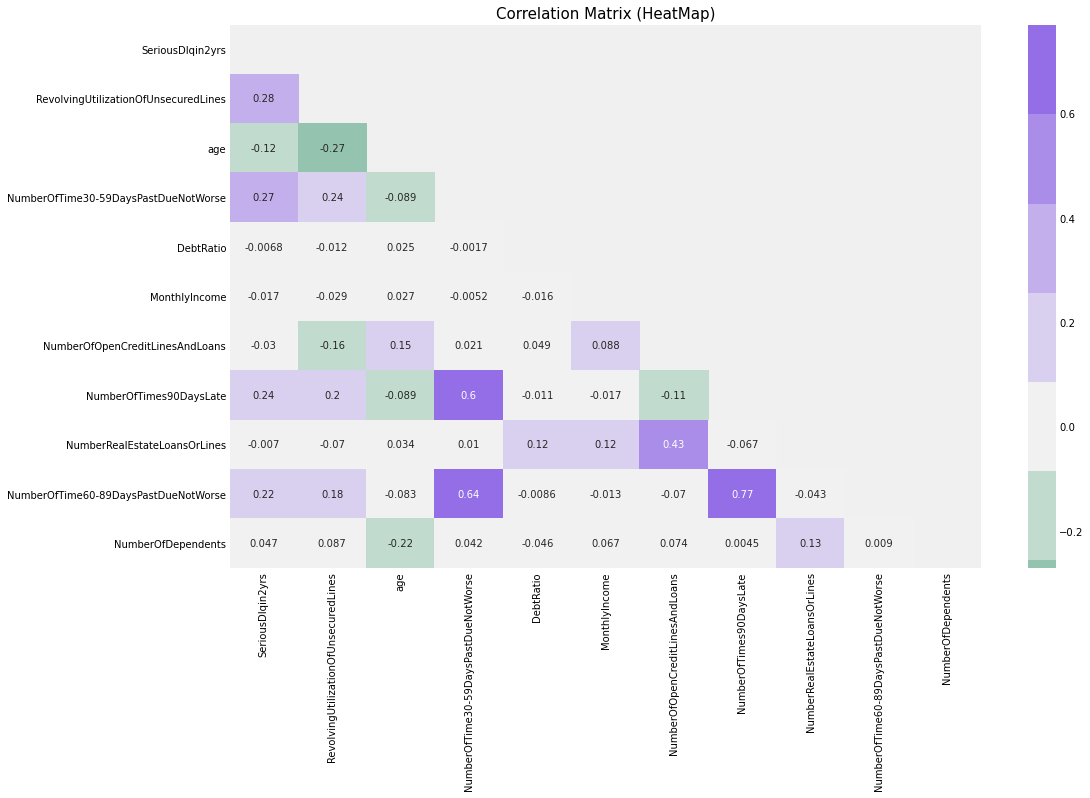

In [36]:
fig = plt.figure(figsize = [15,10])
mask = np.zeros_like(finalTrain.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(finalTrain.corr(), cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9), mask = mask, annot=True, center = 0)
plt.title("Correlation Matrix (HeatMap)", fontsize = 15)

From the correlation heatmap above, we can see the most correlated values to **SeriousDlqin2yrs** are **NumberOfTime30-59DaysPastDueNotWorse** , **NumberOfTime60-89DaysPastDueNotWorse** and **NumberOfTimes90DaysLate**.

Now let's move to the Feature Engineering section of our Notebook

# Feature Engineering

Let's first combine the train and test sets to add features on both the data and conduct further analyses. We will split them later before Model Testing.

In [37]:
SeriousDlqIn2Yrs = finalTrain['SeriousDlqin2yrs']

finalTrain.drop('SeriousDlqin2yrs', axis = 1 , inplace = True)


In [38]:
finalData = pd.concat([finalTrain, finalTest])

finalData.shape

(250934, 10)

Adding some new features:

- **MonthlyIncomePerPerson**: Monthly Income divided by the number of dependents

- **MonthlyDebt**: Monthly Income multiplied by the Debt Ratio

- **isRetired**: Person whose monthly income is 0 and age is greater than 65 (Assumed Retirement Age)

- **RevolvingLines**: Difference between Number of Open Credit Lines and Loans and Number of Real Estate Lines and Loans

- **hasRevolvingLines**: If RevolvingLines exists then 1 else 0

- **hasMultipleRealEstates**: If the Number of Real Estates is greater than 2

- **incomeDivByThousand**: Monthly Income divided by 1000. Fraud might be more likely for these or it might signal the person is in a new job and hasn’t had a percent raise in pay yet. Both groups signal higher risk.

In [39]:
#New Features

finalData['MonthlyIncomePerPerson'] = finalData['MonthlyIncome']/(finalData['NumberOfDependents']+1)
finalData['MonthlyIncomePerPerson'].fillna(0, inplace=True)

finalData['MonthlyDebt'] = finalData['MonthlyIncome']*finalData['DebtRatio']
finalData['MonthlyDebt'].fillna(finalData['DebtRatio'],inplace=True)
finalData['MonthlyDebt'] = np.where(finalData['MonthlyDebt']==0, finalData['DebtRatio'],finalData['MonthlyDebt'])

finalData['isRetired'] = np.where((finalData['age'] > 65), 1, 0)

finalData['RevolvingLines'] = finalData['NumberOfOpenCreditLinesAndLoans']-finalData['NumberRealEstateLoansOrLines']

finalData['hasRevolvingLines']=np.where((finalData['RevolvingLines']>0),1,0)

finalData['hasMultipleRealEstates'] = np.where((finalData['NumberRealEstateLoansOrLines']>=2),1,0)

finalData['incomeDivByThousand'] = finalData['MonthlyIncome']/1000

In [40]:
finalData.shape

(250934, 17)

In [41]:
MissingHandler(finalData)

,Percentage Nulls


We have now added new features to our dataset. Next, we will perform a skewness check on our data by analysing the distributions of individual columns and perform Box Cox Transformation to reduce the skewness.

# Skewness Check and Box Cox Transformation

Let's check the distribution of each values first

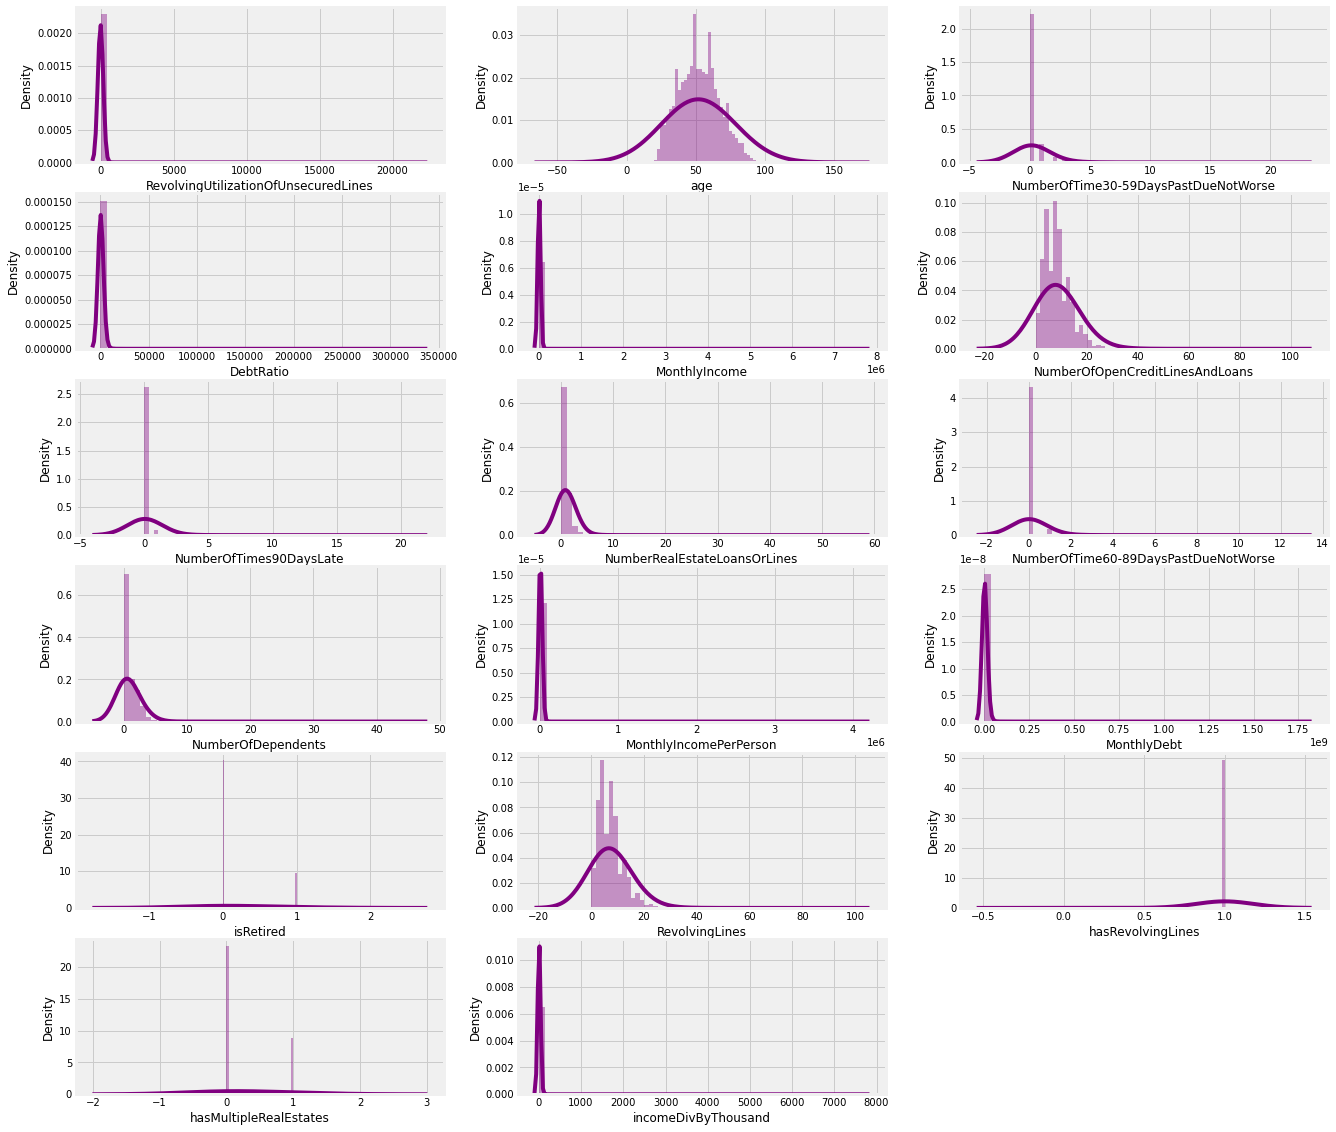

In [42]:
columnList = list(finalData.columns)
columnList

fig = plt.figure(figsize=[20,20])
for col,i in zip(columnList,range(1,19)):
    axes = fig.add_subplot(6,3,i)
    sns.distplot(finalData[col],ax=axes, kde_kws={'bw':1.5}, color='purple')
plt.show()

From the above distribution plots, we can see that majority of our data is skewed in either of the directions. We can only see Age forming close to normal distribution. Let's check the skewness values of each column

In [43]:
def SkewMeasure(df):
    nonObjectColList = df.dtypes[df.dtypes != 'object'].index
    skewM = df[nonObjectColList].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending = False)
    skewM=pd.DataFrame({'skew':skewM})
    return skewM[abs(skewM)>0.5].dropna()

skewM = SkewMeasure(finalData)
skewM

,skew
MonthlyIncome,218.270205
incomeDivByThousand,218.270205
MonthlyIncomePerPerson,206.221804
MonthlyDebt,98.604981
DebtRatio,92.819627
RevolvingUtilizationOfUnsecuredLines,91.721780
NumberOfTimes90DaysLate,15.097509
NumberOfTime60-89DaysPastDueNotWorse,13.509677
NumberOfTime30-59DaysPastDueNotWorse,9.773995
NumberRealEstateLoansOrLines,3.217055


The Skewness is massively high for all the columns. We would apply Box Cox Transformation with **λ = 0.15** in order to reduce this skewness.

In [44]:
for i in skewM.index:
    finalData[i] = special.boxcox1p(finalData[i],0.15) #lambda = 0.15
    
SkewMeasure(finalData)

,skew
RevolvingUtilizationOfUnsecuredLines,23.234640
NumberOfTimes90DaysLate,6.787000
NumberOfTime60-89DaysPastDueNotWorse,6.602180
NumberOfTime30-59DaysPastDueNotWorse,3.212010
DebtRatio,1.958314
MonthlyDebt,1.817649
isRetired,1.564456
hasMultipleRealEstates,1.008475
NumberOfDependents,0.947591
incomeDivByThousand,0.708168


The Skewness have reduced on a much higher scale now that the Box Cox Transformation is applied. Let's check the distribution plots for individual columns again:

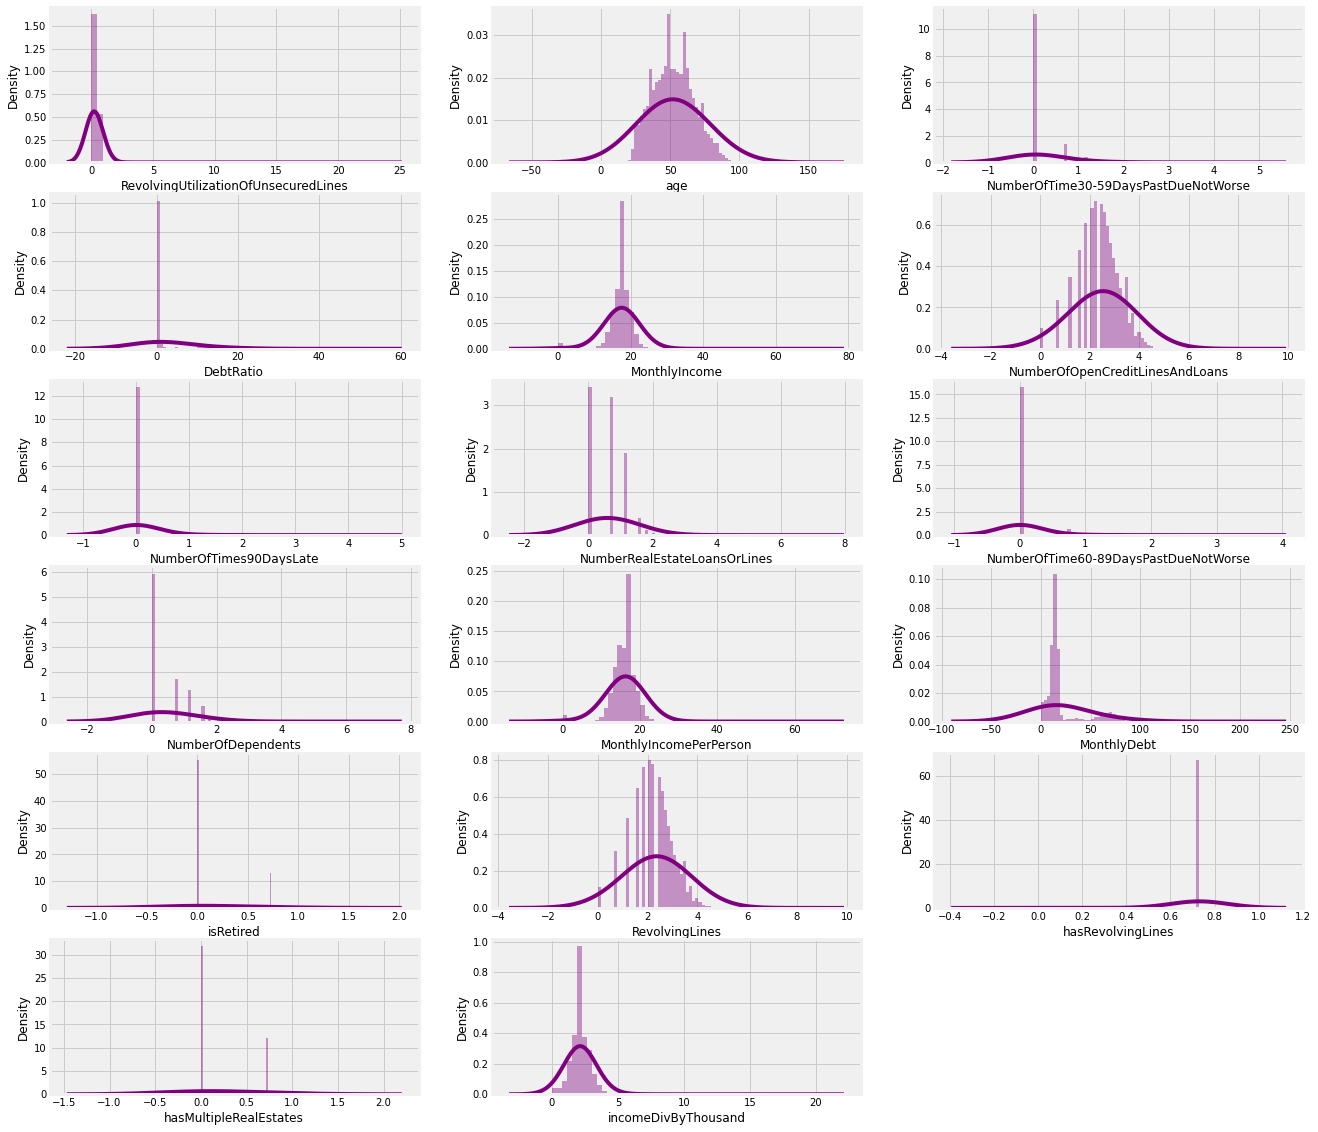

In [45]:
fig = plt.figure(figsize=[20,20])
for col,i in zip(columnList,range(1,19)):
    axes = fig.add_subplot(6,3,i)
    sns.distplot(finalData[col],ax=axes, kde_kws={'bw':1.5}, color='purple')
plt.show()

As you can see, our graphs look much better now.

# Model Training

## Train-Validation Split

We will currently split the train and validation sets into a 70-30 proportion.

In [46]:
trainDF = finalData[:len(finalTrain)]
testDF = finalData[len(finalTrain):]
print(trainDF.shape)
print(testDF.shape)

(149431, 17)
(101503, 17)


In [47]:
xTrain, xTest, yTrain, yTest = model_selection.train_test_split(trainDF.to_numpy(),SeriousDlqIn2Yrs.to_numpy(),test_size=0.3,random_state=2020)

## LightGBM

**Hyperparameter Tuning**

In [48]:
lgbAttributes = lgb.LGBMClassifier(objective='binary', n_jobs=-1, random_state=2020, importance_type='gain')

lgbParameters = {
    'max_depth' : [2,3,4,5],
    'learning_rate': [0.05, 0.1,0.125,0.15],
    'colsample_bytree' : [0.2,0.4,0.6,0.8,1],
    'n_estimators' : [400,500,600,700,800,900],
    'min_split_gain' : [0.15,0.20,0.25,0.3,0.35], #equivalent to gamma in XGBoost
    'subsample': [0.6,0.7,0.8,0.9,1],
    'min_child_weight': [6,7,8,9,10],
    'scale_pos_weight': [10,15,20],
    'min_data_in_leaf' : [100,200,300,400,500,600,700,800,900],
    'num_leaves' : [20,30,40,50,60,70,80,90,100]
}

lgbModel = model_selection.RandomizedSearchCV(lgbAttributes, param_distributions = lgbParameters, cv = 5, random_state=2020)

lgbModel.fit(xTrain,yTrain.flatten(),feature_name=trainDF.columns.to_list())

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGB

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(importance_type='gain',
                                            objective='binary',
                                            random_state=2020),
                   param_distributions={'colsample_bytree': [0.2, 0.4, 0.6, 0.8,
                                                             1],
                                        'learning_rate': [0.05, 0.1, 0.125,
                                                          0.15],
                                        'max_depth': [2, 3, 4, 5],
                                        'min_child_weight': [6, 7, 8, 9, 10],
                                        'min_data_in_leaf': [100, 200, 300, 400,
                                                             500, 600, 700, 800,
                                                             900],
                                        'min_split_gain': [0.15, 0.2, 0.25, 0.3,
                                     

In [49]:
bestEstimatorLGB = lgbModel.best_estimator_
bestEstimatorLGB

LGBMClassifier(colsample_bytree=0.4, importance_type='gain', max_depth=5,
               min_child_weight=6, min_data_in_leaf=600, min_split_gain=0.25,
               n_estimators=900, num_leaves=50, objective='binary',
               random_state=2020, scale_pos_weight=10, subsample=0.9)

Saving the best estimator from RandomSearchCV

In [50]:
bestEstimatorLGB = lgb.LGBMClassifier(colsample_bytree=0.4, importance_type='gain', max_depth=5,
               min_child_weight=6, min_data_in_leaf=600, min_split_gain=0.25,
               n_estimators=900, num_leaves=50, objective='binary',
               random_state=2020, scale_pos_weight=10, subsample=0.9).fit(xTrain,yTrain.flatten(),feature_name=trainDF.columns.to_list())

In [51]:
yPredLGB = bestEstimatorLGB.predict_proba(xTest)
yPredLGB = yPredLGB[:,1]

In [52]:
yTestPredLGB = bestEstimatorLGB.predict(xTest)
print(metrics.classification_report(yTest,yTestPredLGB))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92     41862
           1       0.27      0.67      0.38      2968

    accuracy                           0.86     44830
   macro avg       0.62      0.77      0.65     44830
weighted avg       0.93      0.86      0.88     44830



In [53]:
metrics.confusion_matrix(yTest,yTestPredLGB)

array([[36372,  5490],
       [  982,  1986]])

In [54]:
LGBMMetrics = pd.DataFrame({'Model': 'LightGBM', 
                            'MSE': round(metrics.mean_squared_error(yTest, yTestPredLGB)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(yTest, yTestPredLGB)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(yTest, yTestPredLGB)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(yTest, yTestPredLGB)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(yTest, yTestPredLGB)*100),2),
                            'Accuracy Train' : round(bestEstimatorLGB.score(xTrain, yTrain) * 100,2),
                            'Accuracy Test' : round(bestEstimatorLGB.score(xTest, yTest) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(yTest, yTestPredLGB, beta=2)*100,2)},index=[1])

LGBMMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
1,LightGBM,14.44,3.8,14.44,6.94,2.63,86.55,85.56,51.32


**ROC AUC**

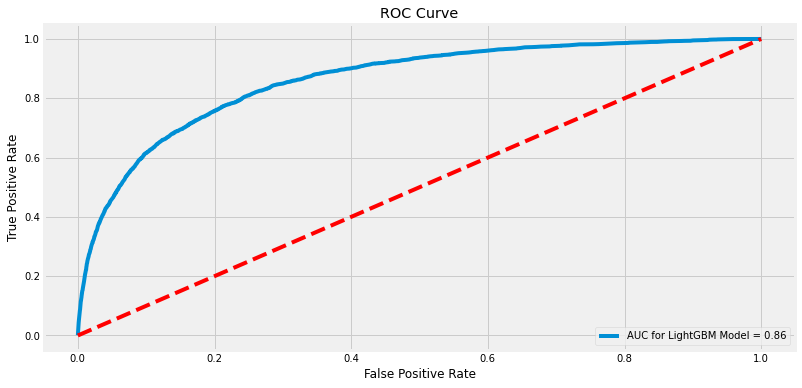

In [55]:
fpr,tpr,_ = metrics.roc_curve(yTest,yPredLGB)
rocAuc = metrics.auc(fpr, tpr)
plt.figure(figsize=(12,6))
plt.title('ROC Curve')
sns.lineplot(fpr, tpr, label = 'AUC for LightGBM Model = %0.2f' % rocAuc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**FEATURE IMPORTANCE**

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

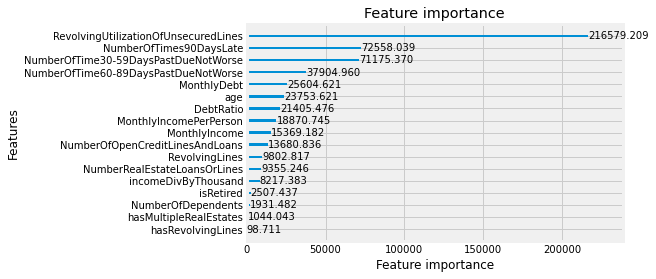

In [56]:
lgb.plot_importance(bestEstimatorLGB, importance_type='gain')

**FEATURE IMPORTANCE USING SHAP**

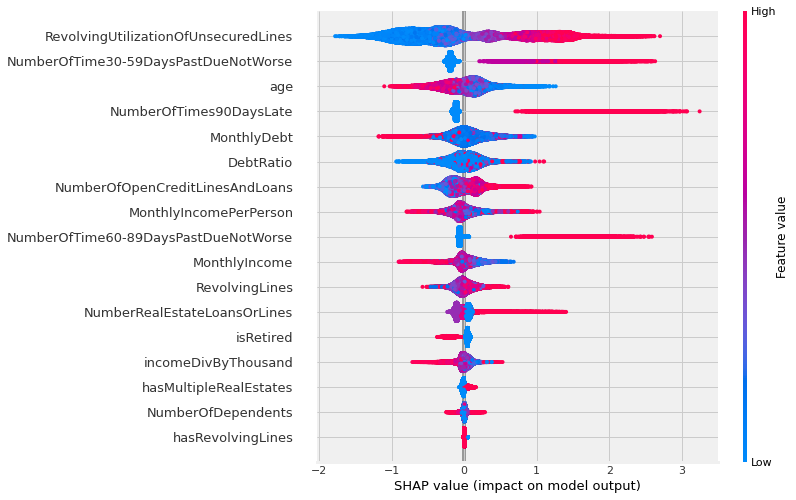

In [57]:
X = pd.DataFrame(xTrain, columns=trainDF.columns.to_list())

explainer = shap.TreeExplainer(bestEstimatorLGB)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values[1], X)

## XGBoost

**Hyperparameter Tuning**

In [59]:
xgbAttribute = xgs.XGBClassifier(n_jobs=-1, gpu_id=0)

xgbParameters = {
    'max_depth' : [2,3,4,5,6,7,8],
    'learning_rate':[0.05,0.1,0.125,0.15],
    'colsample_bytree' : [0.2,0.4,0.6,0.8,1],
    'n_estimators' : [400,500,600,700,800,900],
    'gamma':[0.15,0.20,0.25,0.3,0.35],
    'subsample': [0.6,0.7,0.8,0.9,1],
    'min_child_weight': [6,7,8,9,10],
    'scale_pos_weight': [10,15,20]
    
}

xgbModel = model_selection.RandomizedSearchCV(xgbAttribute, param_distributions = xgbParameters, cv = 5, random_state=2020)

xgbModel.fit(xTrain,yTrain.flatten())

[17:47:16] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:47:24] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:47:32] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:47:40] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

[17:50:25] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:30] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:35] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:44] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=0, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_j...
                                           validate_parameters=None,
                                           verbosity=None),
                   param_distributions={'colsample_

In [60]:
bestEstimatorXGB = xgbModel.best_estimator_
bestEstimatorXGB

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.25, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.125, max_delta_step=0, max_depth=5,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Setting the best estimator from RandomizedSearchCV

In [63]:
bestEstimatorXGB = xgs.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.25, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.125, max_delta_step=0, max_depth=5,
              min_child_weight=9,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=800, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=1, validate_parameters=1, verbosity=None).fit(xTrain,yTrain.flatten())

[17:55:38] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [64]:
yPredXGB = bestEstimatorXGB.predict_proba(xTest)
yPredXGB = yPredXGB[:,1]

yTestPredXGB = bestEstimatorXGB.predict(xTest)
print(metrics.classification_report(yTest,yTestPredXGB))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     41862
           1       0.29      0.62      0.39      2968

    accuracy                           0.87     44830
   macro avg       0.63      0.76      0.66     44830
weighted avg       0.93      0.87      0.89     44830



In [65]:
metrics.confusion_matrix(yTest,yTestPredXGB)

array([[37259,  4603],
       [ 1127,  1841]])

In [66]:
XGBMetrics = pd.DataFrame({'Model': 'XGBoost', 
                            'MSE': round(metrics.mean_squared_error(yTest, yTestPredXGB)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(yTest, yTestPredXGB)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(yTest, yTestPredXGB)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(yTest, yTestPredXGB)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(yTest, yTestPredXGB)*100),2),
                            'Accuracy Train' : round(bestEstimatorLGB.score(xTrain, yTrain) * 100,2),
                            'Accuracy Test' : round(bestEstimatorLGB.score(xTest, yTest) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(yTest, yTestPredXGB, beta=2)*100,2)},index=[2])

XGBMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
2,XGBoost,12.78,3.58,12.78,6.14,2.48,86.55,85.56,50.26


**ROC AUC**

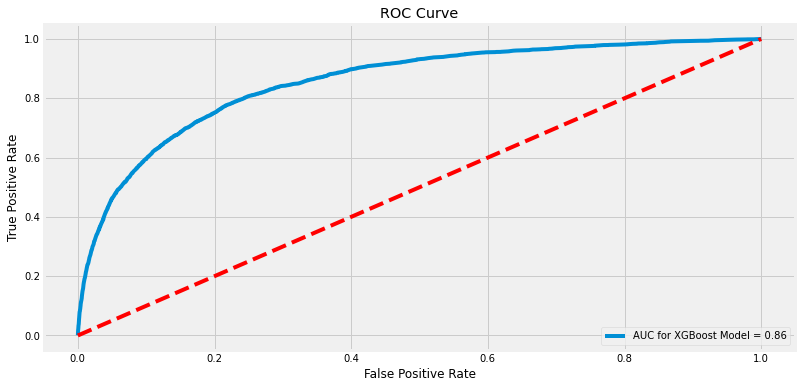

In [67]:
fpr,tpr,_ = metrics.roc_curve(yTest,yPredXGB)
rocAuc = metrics.auc(fpr, tpr)
plt.figure(figsize=(12,6))
plt.title('ROC Curve')
sns.lineplot(fpr, tpr, label = 'AUC for XGBoost Model = %0.2f' % rocAuc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**FEATURE IMPORTANCE**

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

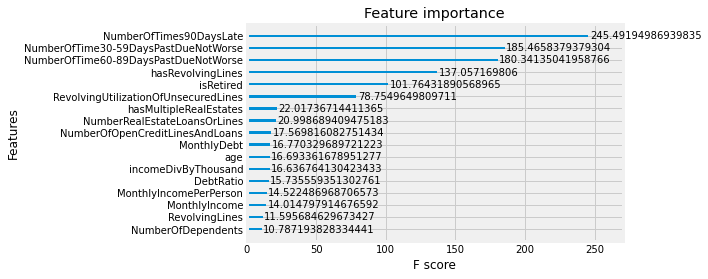

In [68]:
bestEstimatorXGB.get_booster().feature_names = trainDF.columns.to_list()
xgs.plot_importance(bestEstimatorXGB, importance_type='gain')

**FEATURE IMPORTANCE USING SHAP**

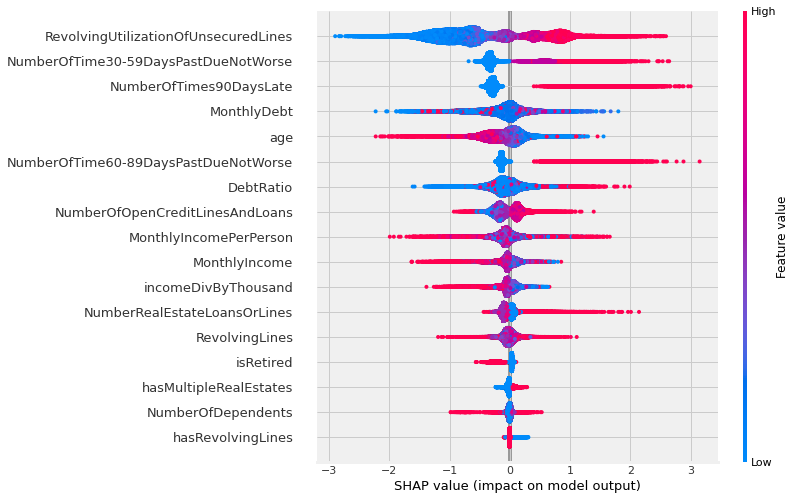

In [69]:
# resolve a conflict/bug with latest version of XGBoost and SHAP
mybooster = bestEstimatorXGB.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun


X = pd.DataFrame(xTrain, columns=trainDF.columns.to_list())

explainer = shap.TreeExplainer(mybooster)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [70]:
frames = [LGBMMetrics, XGBMetrics]
TrainingResult = pd.concat(frames)
TrainingResult.T

,1,2
Model,LightGBM,XGBoost
MSE,14.44,12.78
RMSE,3.8,3.58
MAE,14.44,12.78
MSLE,6.94,6.14
RMSLE,2.63,2.48
Accuracy Train,86.55,86.55
Accuracy Test,85.56,85.56
F-Beta Score (β=2),51.32,50.26


### LGBM Submission

Since, we can see our LGBM performs better, we will submit this. (Late Submission)

In [71]:
lgbProbs = bestEstimatorLGB.predict_proba(testDF)
lgbDF = pd.DataFrame({'ID': testID, 'Probability': lgbProbs[:,1]})
lgbDF.to_csv('submission.csv', index=False)

Hence the delinquency probabilities.

In [72]:
lgbDF

,ID,Probability
0,1,0.263093
1,2,0.270376
2,3,0.172207
3,4,0.300624
4,5,0.414314
...,...,...
101498,101499,0.149007
101499,101500,0.940072
101500,101501,0.066354
101501,101502,0.314286
